# Bleeding Correction

This notebook will cover the bleeding correction step of the BayesTME pipeline, using our zebrafish dataset as an example.

First download the dataset from https://www.dropbox.com/sh/1nbaa3dxcgco6oh/AACUD6KJT7KFGD7y7XQ1ndz-a?dl=0 and save it in your current working directory.


This data comes from the 10X Genomics Spaceranger pipeline (https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/installation), so we use the SpatialExpressionDataset.read_spaceranger method:

In [1]:
from bayestme import data

stdata = data.SpatialExpressionDataset.read_spaceranger("../A1_spaceranger_output")

We first visualize the tissue sample, and plot the expression of a single gene:

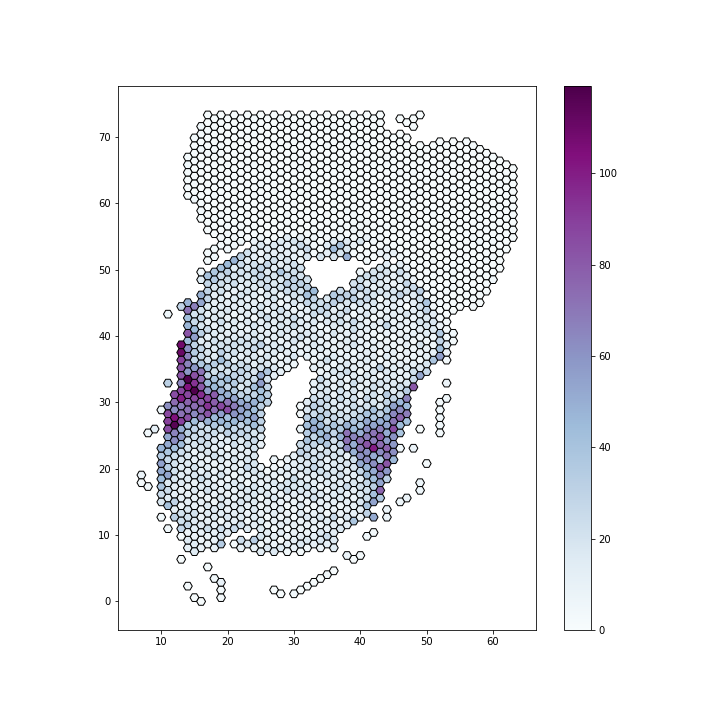

In [23]:
from bayestme import plotting
from IPython.display import Image
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 10)
plotting.plot_gene_raw_counts(stdata=stdata, gene='mt-nd2', output_file='mt-nd2.png')

Image('mt-nd2.png')

Next we will apply our gene filtering criteria, selecting genes with the most spatial variation, that appear in less than 95% of spots, and that are not ribosomal.

In [9]:
from bayestme import gene_filtering

stddev_filtered = gene_filtering.select_top_genes_by_standard_deviation(
    stdata, n_gene=20)

spot_threshold_filtered = gene_filtering.filter_genes_by_spot_threshold(
    stddev_filtered, spot_threshold=0.95)

stdata_filtered = gene_filtering.filter_ribosome_genes(spot_threshold_filtered)

In [10]:
print('{}/{} genes selected'.format(len(stdata_filtered.gene_names), len(stdata.gene_names)))

13/32268 genes selected


At this point we apply bleeding correction. 

The parameter "n_top" controls how many genes we look at in order to estimate the bleeding parameters.
Bleeding is not gene specific, so we can use the pattern learned from one set of genes to correct another. Generally we just want to choose genes with good spatial variance in order to estimate the bleeding parameters. We rank the genes by spatial variance and only use the top `n_top` of them for estimating the bleeding parameters

In this example we will use a relatively small `n_top` = 20, normally we should use a larger number.

The bleeding model is fit by alternating minimization. 
At each iteration, BayesTME alternates between estimating the basis functions ζˆ and global rates ρˆ0g, and estimating the latent true UMI rates μˆig.

The parameter "max steps" controls how many rounds of alternating minimization to go through. Normally we set this to 5 or more, but for this example we will use a smaller number to make it faster.

The output of the `clean_bleed` will be a tuple of two objects, the first object is the input stdata object, but with the read values set to the new corrected values. The second object is the bleeding correction result, and contains the actual bleeding parameters learned.

In [15]:
from bayestme import bleeding_correction

cleaned_dataset, bleed_correction_result = bleeding_correction.clean_bleed(
    dataset=stdata_filtered,
    n_top=20,
    local_weight=None,
    max_steps=3
)

Fitting basis functions to first 13 genes

Step 1/3
	Loss: 13876.72

Step 2/3
	Loss: 13874.72

Step 3/3
	Loss: 13873.83

Gene 1/13

Gene 2/13

Gene 3/13

Gene 4/13

Gene 5/13

Gene 6/13

Gene 7/13

Gene 8/13

Gene 9/13

Gene 10/13

Gene 11/13

Gene 12/13

Gene 13/13


BayesTME includes plotting methods for visualizing the results of bleeding correction. 

This method will create plots of raw vs corrected read counts, for the top N genes ranked by spatial variation.

In [16]:
plt.rcParams["figure.figsize"] = (5, 5)
bleeding_correction.create_top_n_gene_bleeding_plots(
        dataset=stdata_filtered,
        corrected_dataset=cleaned_dataset,
        bleed_result=bleed_correction_result,
        output_dir='.',
        output_format='png',
        n_genes=13)

Plot saved as ./ckmb_bleeding_plot.png
Plot saved as ./mylpfa_bleeding_plot.png
Plot saved as ./ckma_bleeding_plot.png
Plot saved as ./pvalb3_bleeding_plot.png
Plot saved as ./myhc4_bleeding_plot.png
Plot saved as ./gapdh_bleeding_plot.png
Plot saved as ./mt-nd1_bleeding_plot.png
Plot saved as ./atp2a1l_bleeding_plot.png
Plot saved as ./tpma_bleeding_plot.png
Plot saved as ./mylz3_bleeding_plot.png
Plot saved as ./tnnt3b_bleeding_plot.png
Plot saved as ./mt-nd2_bleeding_plot.png
Plot saved as ./myhz1.1_bleeding_plot.png


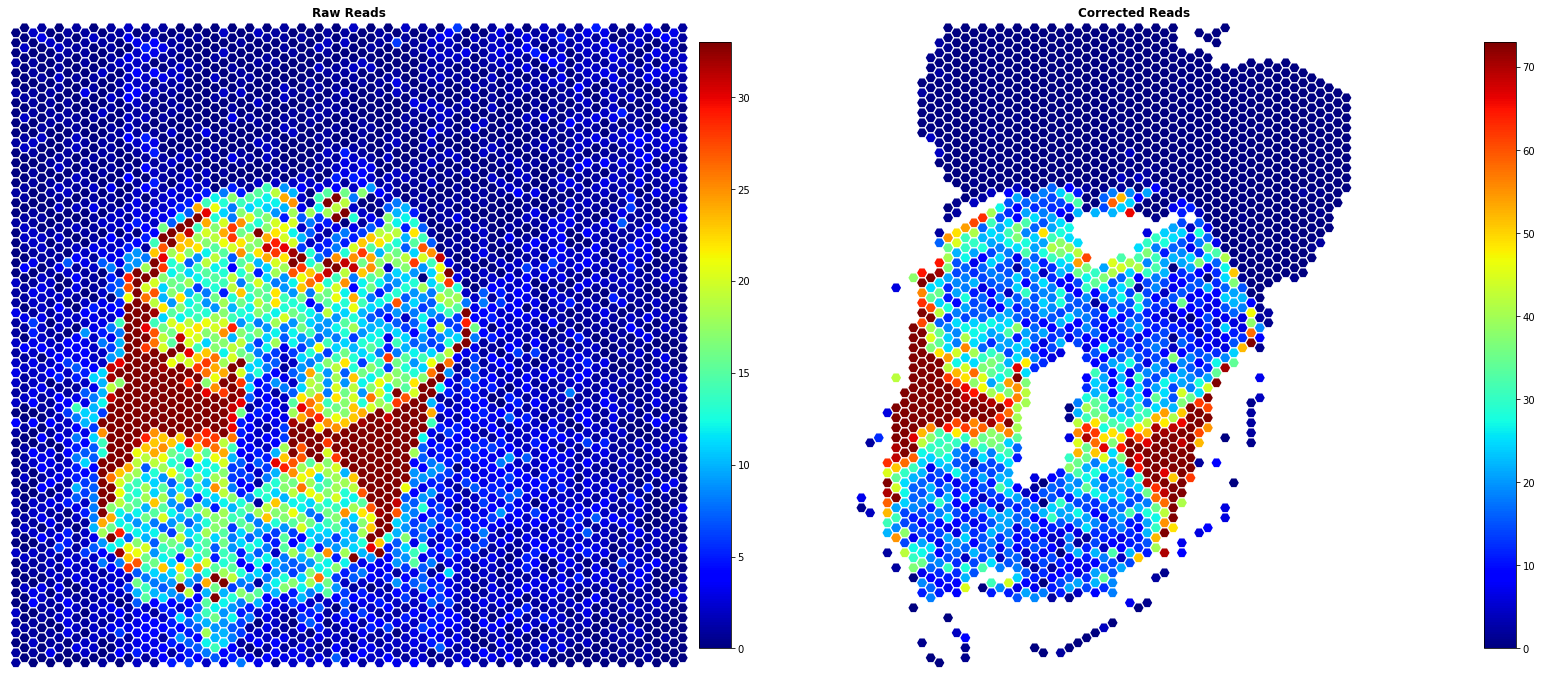

In [22]:
Image('./mt-nd2_bleeding_plot.png')

We also create plots of the estimated bleed vectors for the top genes.

For each spot the bleed vector indicates where reads for the marker in that spot likely came from. We see the vectors for outside-tissue spots point towards the in-tissue spots in the middle, indicating their reads came from there.

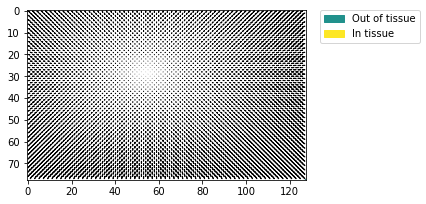

In [25]:
Image('./bleed-vectors-mt-nd2.png')